In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
df = pd.read_csv("/content/data/daily_min_temp.csv", parse_dates=["Date"], index_col = "Date")
df.head()

Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8

In [5]:
df = df.resample("W").mean()

<Axes: xlabel='Date'>

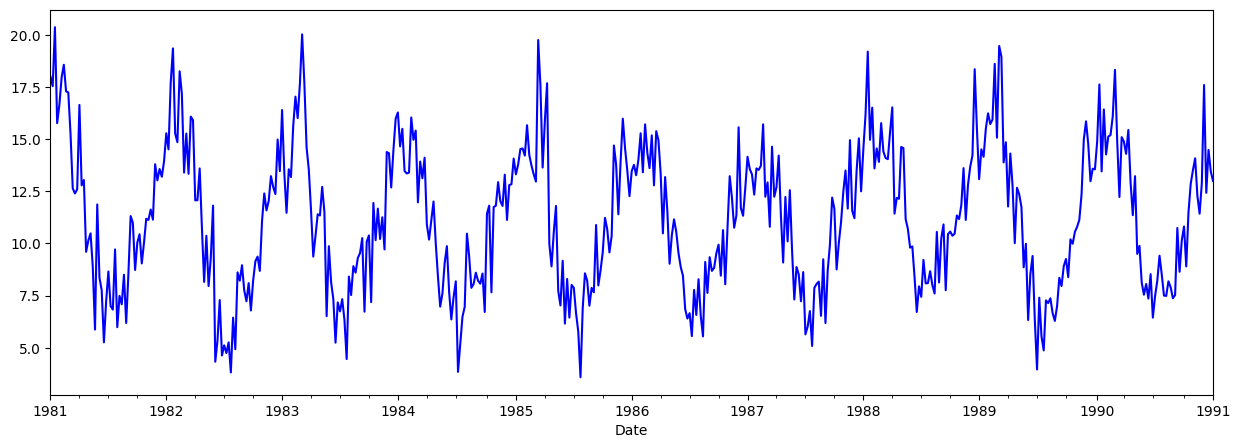

In [6]:
df.Temp.plot(figsize=(15, 5), color='b')

<h2> Dataset splitting

In [7]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((418, 1), (105, 1))

<h2> Dataset & Dataloader

In [8]:
from torch.utils.data import TensorDataset, DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [20]:
seq_len = 14
bs = 16

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (29, 14, 1)
Note: last 11 data excluded

(N, S, F): (7, 14, 1)
Note: last 6 data excluded



<h2> Arsitektur & Config

In [21]:
from jcopdl.layers import linear_block

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout) # NFS -> N/Batch First maka True
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden
         # hidden bisa tidak perlu dikeluarkan, tapi nanti di loop function tidak usah di define

In [23]:
train_set.n_feature

1

In [24]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers" : 2,
    "dropout" : 0,
    "seq_len": train_set.n_seq
})

<h2> Training Preparation -> MCOC

In [25]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model")

In [26]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        #output, hidden -> hidden bisa dibuang jika tidak digunakan
        output, hidden = model(feature, None) # inputnya ada 2, hiddennya None, maka hidden nya otomatis 0
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 127.9349 | Test_cost  = 126.1410 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 117.4485 | Test_cost  = 116.2633 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 108.0751 | Test_cost  = 107.2641 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 99.4680 | Test_cost  = 98.9386 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 91.5174 | Test_cost  = 91.3555 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 84.2974 | Test_cost  = 84.5548 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 77.8477 | Test_cost  = 78.5645 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 72.1954 | Test_cost  = 73.3913 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 67.3326 | Test_cost  = 68.9718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 63.1821 | Test_cost  = 65.1838 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 59.6203 | Test_cost  = 61.8961 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 56.5234 | Test_cost  = 58.9997 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 53.7906 | Test_cost  = 56.4113 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 51.3453 | Test_cost  = 54.0679 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 49.1294 | Test_cost  = 51.9217 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 47.0983 | Test_cost  = 49.9354 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 45.2175 | Test_cost  = 48.0794 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 43.4593 | Test_cost  = 46.3309 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 41.8029 | Test_cost  = 44.6729 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 40.2329 | Test_cost  = 43.0939 | 


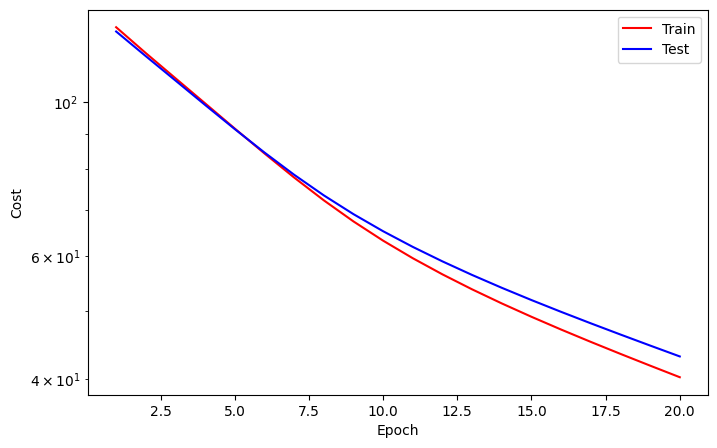

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 38.7390 | Test_cost  = 41.5864 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 37.3143 | Test_cost  = 40.1452 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 35.9541 | Test_cost  = 38.7668 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 34.6552 | Test_cost  = 37.4484 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 33.4147 | Test_cost  = 36.1877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 32.2303 | Test_cost  = 34.9823 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 31.0996 | Test_cost  = 33.8301 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 30.0208 | Test_cost  = 32.7292 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 28.9917 | Test_cost  = 31.6777 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 28.0104 | Test_cost  = 30.6736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 27.0752 | Test_cost  = 29.7153 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 26.1844 | Test_cost  = 28.8011 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 25.3361 | Test_cost  = 27.9293 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 24.5288 | Test_cost  = 27.0983 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 23.7609 | Test_cost  = 26.3066 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 23.0309 | Test_cost  = 25.5527 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 22.3373 | Test_cost  = 24.8351 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 21.6786 | Test_cost  = 24.1524 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 21.0535 | Test_cost  = 23.5033 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 20.4606 | Test_cost  = 22.8863 | 


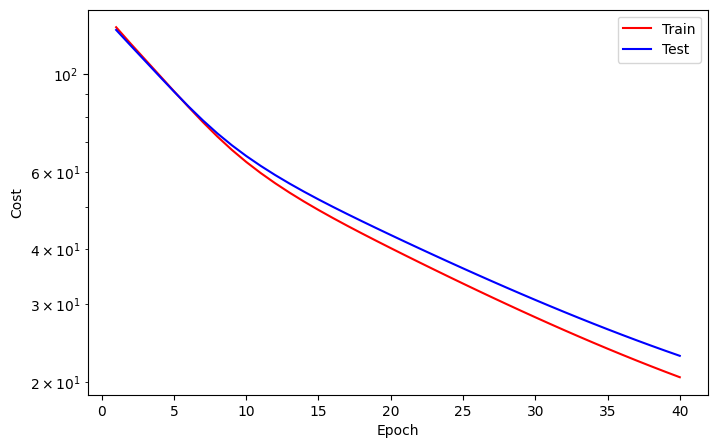

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 19.8985 | Test_cost  = 22.3003 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 19.3660 | Test_cost  = 21.7439 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 18.8618 | Test_cost  = 21.2159 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 18.3847 | Test_cost  = 20.7151 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 17.9336 | Test_cost  = 20.2404 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 17.5074 | Test_cost  = 19.7907 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 17.1048 | Test_cost  = 19.3648 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 16.7248 | Test_cost  = 18.9618 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 16.3665 | Test_cost  = 18.5805 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 16.0288 | Test_cost  = 18.2201 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 15.7107 | Test_cost  = 17.8796 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 15.4114 | Test_cost  = 17.5581 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 15.1298 | Test_cost  = 17.2545 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 14.8652 | Test_cost  = 16.9683 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 14.6167 | Test_cost  = 16.6983 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 14.3835 | Test_cost  = 16.4440 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 14.1648 | Test_cost  = 16.2045 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 13.9598 | Test_cost  = 15.9791 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 13.7679 | Test_cost  = 15.7670 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 13.5883 | Test_cost  = 15.5676 | 


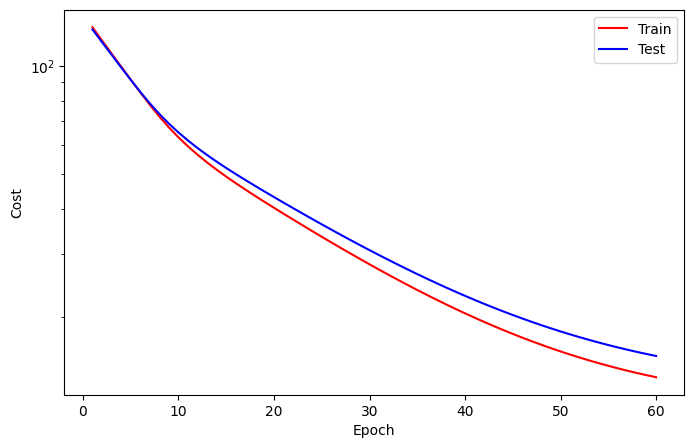

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 13.4204 | Test_cost  = 15.3802 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 13.2635 | Test_cost  = 15.2042 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 13.1171 | Test_cost  = 15.0390 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 12.9804 | Test_cost  = 14.8839 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 12.8531 | Test_cost  = 14.7385 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 12.7344 | Test_cost  = 14.6022 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 12.6240 | Test_cost  = 14.4745 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 12.5213 | Test_cost  = 14.3550 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 12.4259 | Test_cost  = 14.2430 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 12.3373 | Test_cost  = 14.1383 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 12.2551 | Test_cost  = 14.0403 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 12.1788 | Test_cost  = 13.9488 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 12.1082 | Test_cost  = 13.8632 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 12.0428 | Test_cost  = 13.7833 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 11.9824 | Test_cost  = 13.7086 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 11.9265 | Test_cost  = 13.6390 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 11.8748 | Test_cost  = 13.5740 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 11.8272 | Test_cost  = 13.5133 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 11.7832 | Test_cost  = 13.4568 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 11.7427 | Test_cost  = 13.4041 | 


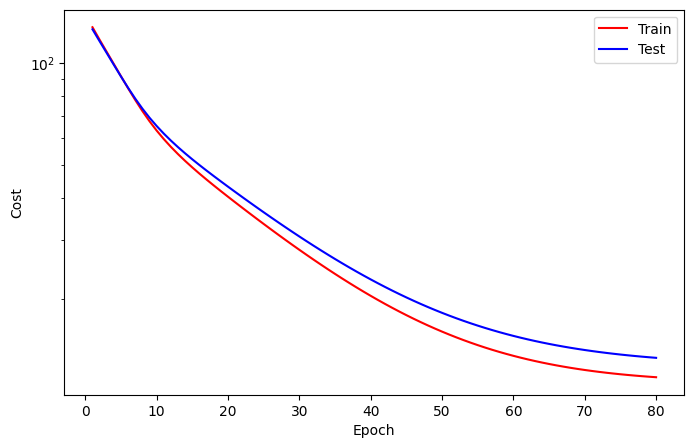

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

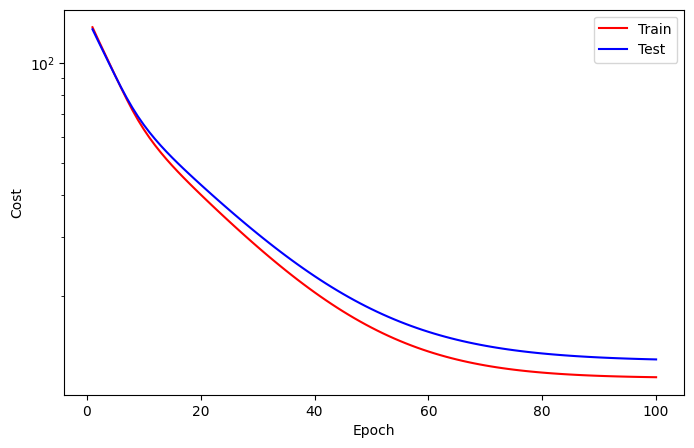

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 11.3659 | Test_cost  = 12.8501 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 11.3602 | Test_cost  = 12.8391 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 11.3550 | Test_cost  = 12.8289 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 11.3502 | Test_cost  = 12.8194 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 11.3459 | Test_cost  = 12.8105 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   106
Train_cost  = 11.3420 | Test_cost  = 12.8023 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   107
Train_cost  = 11.3384 | Test_cost  = 12.7946 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   108
Train_cost  = 11.3351 | Test_cost  = 12.7874 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   109
Train_cost  = 11.3322 | Test_cost  = 12.7807 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   110
Train_cost  = 11.3295 | Test_cost  = 12.7744 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   111
Train_cost  = 11.3270 | Test_cost  = 12.7686 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   112
Train_cost  = 11.3247 | Test_cost  = 12.7631 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 11.2862 | Test_cost  = 12.6736 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 11.2855 | Test_cost  = 12.6727 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 11.2847 | Test_cost  = 12.6718 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 11.2839 | Test_cost  = 12.6709 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 11.2831 | Test_cost  = 12.6700 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 11.2822 | Test_cost  = 12.6690 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 11.2814 | Test_cost  = 12.6680 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 11.2804 | Test_cost  = 12.6670 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 11.2795 | Test_cost  = 12.6659 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 11.2785 | Test_cost  = 12.6647 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 11.2774 | Test_cost  = 12.6635 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 11.2763 | Test_cost  = 12.6622 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 11.2750 | Test_cost  = 12.6608 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 11.2328 | Test_cost  = 12.6138 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 11.2250 | Test_cost  = 12.6049 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 11.2148 | Test_cost  = 12.5928 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 11.2003 | Test_cost  = 12.5750 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 11.1782 | Test_cost  = 12.5472 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 11.1421 | Test_cost  = 12.5051 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 11.0878 | Test_cost  = 12.4642 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 11.0342 | Test_cost  = 12.4478 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 10.9999 | Test_cost  = 12.4171 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 10.9534 | Test_cost  = 12.3457 | 


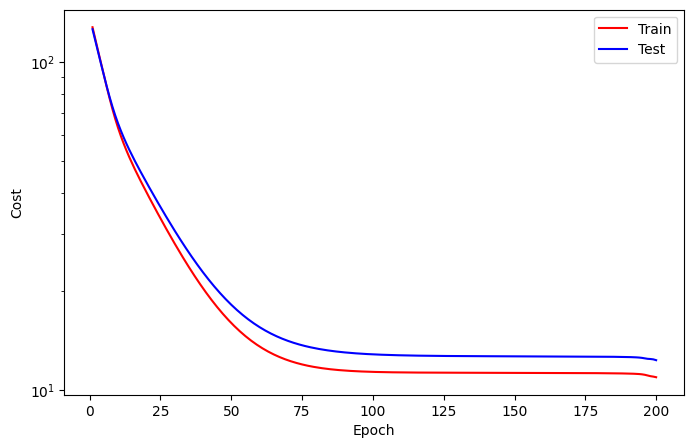

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 10.8793 | Test_cost  = 12.2468 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 10.7937 | Test_cost  = 12.1466 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 10.7153 | Test_cost  = 12.0533 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 7.5944 | Test_cost  = 8.4584 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 7.4427 | Test_cost  = 8.3021 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 7.3100 | Test_cost  = 8.1107 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 7.1730 | Test_cost  = 7.9417 | 


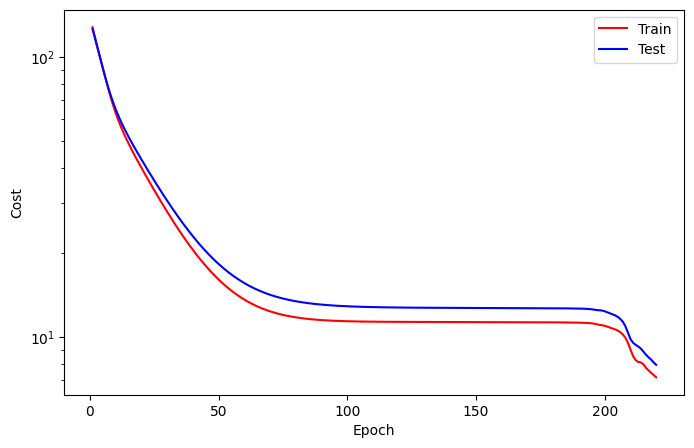

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 7.0505 | Test_cost  = 7.7936 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 6.9330 | Test_cost  = 7.6587 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 6.8240 | Test_cost  = 7.5311 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 6.7246 | Test_cost  = 7.4100 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 6.6221 | Test_cost  = 7.2977 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 6.5217 | Test_cost  = 7.1891 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 6.4273 | Test_cost  = 7.0880 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 6.3392 | Test_cost  = 6.9884 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 6.2514 | Test_cost  = 6.8905 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 5.3444 | Test_cost  = 5.7815 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 5.2930 | Test_cost  = 5.7141 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 5.2438 | Test_cost  = 5.6475 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 5.1972 | Test_cost  = 5.5799 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 5.1514 | Test_cost  = 5.5163 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 5.1081 | Test_cost  = 5.4540 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 5.0669 | Test_cost  = 5.3927 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 5.0267 | Test_cost  = 5.3359 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 4.9887 | Test_cost  = 5.2799 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 4.9523 | Test_cost  = 5.2252 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 4.9168 | Test_cost  = 5.1734 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 4.8832 | Test_cost  = 5.1215 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 4.8507 | Test_cost  = 5.0712 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

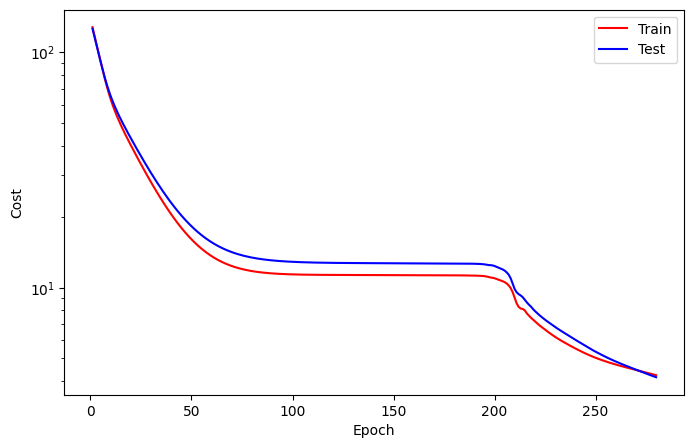

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 4.2172 | Test_cost  = 4.1266 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 4.1956 | Test_cost  = 4.0992 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 4.1743 | Test_cost  = 4.0724 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 4.1532 | Test_cost  = 4.0463 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 4.1324 | Test_cost  = 4.0206 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 4.1119 | Test_cost  = 3.9952 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 4.0916 | Test_cost  = 3.9697 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 4.0715 | Test_cost  = 3.9442 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 4.0516 | Test_cost  = 3.9185 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 4.0321 | Test_cost  = 3.8927 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 4.0128 | Test_cost  = 3.8669 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 3.9939 | Test_cost  = 3.8411 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 3.5816 | Test_cost  = 3.2371 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 3.5733 | Test_cost  = 3.2245 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 3.5651 | Test_cost  = 3.2120 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 3.5570 | Test_cost  = 3.1997 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 3.5490 | Test_cost  = 3.1875 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 3.5411 | Test_cost  = 3.1754 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 3.5332 | Test_cost  = 3.1635 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 3.5255 | Test_cost  = 3.1517 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 3.5178 | Test_cost  = 3.1400 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 3.5103 | Test_cost  = 3.1285 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 3.5028 | Test_cost  = 3.1172 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 3.4955 | Test_cost  = 3.1059 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 3.4884 | Test_cost  = 3.0949 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 3.3900 | Test_cost  = 2.9413 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   357
Train_cost  = 3.3850 | Test_cost  = 2.9346 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   358
Train_cost  = 3.3800 | Test_cost  = 2.9282 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   359
Train_cost  = 3.3751 | Test_cost  = 2.9220 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   360
Train_cost  = 3.3702 | Test_cost  = 2.9159 | 


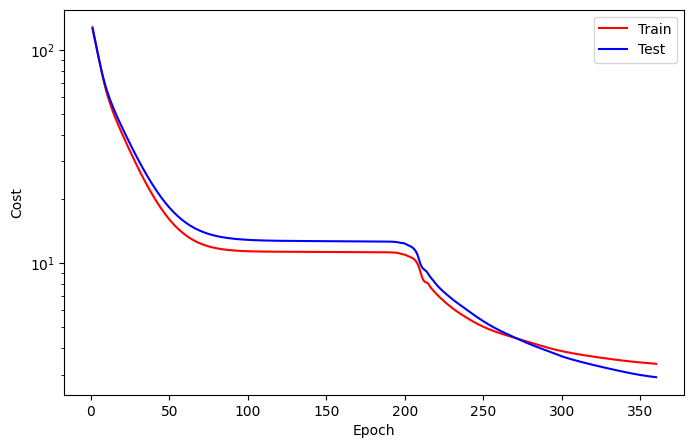

Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   361
Train_cost  = 3.3655 | Test_cost  = 2.9100 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 3.3609 | Test_cost  = 2.9042 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 3.3563 | Test_cost  = 2.8986 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 3.3518 | Test_cost  = 2.8931 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 3.3474 | Test_cost  = 2.8877 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 3.3431 | Test_cost  = 2.8824 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 3.3388 | Test_cost  = 2.8772 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 3.3345 | Test_cost  = 2.8722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   383
Train_cost  = 3.2744 | Test_cost  = 2.8090 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   384
Train_cost  = 3.2706 | Test_cost  = 2.8055 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   385
Train_cost  = 3.2667 | Test_cost  = 2.8021 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 3.2629 | Test_cost  = 2.7988 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 3.2590 | Test_cost  = 2.7955 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 3.2552 | Test_cost  = 2.7923 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 3.2514 | Test_cost  = 2.7892 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 3.2476 | Test_cost  = 2.7862 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 3.2438 | Test_cost  = 2.7832 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 3.2400 | Test_cost  = 2.7803 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 3.2361 | Test_cost  = 2.7775 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 3.2323 | Test_cost  = 2.7748 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 3.2285 | Test_cost  = 2.7722 | 


Train:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   421
Train_cost  = 3.1124 | Test_cost  = 2.7414 | 
==> EarlyStop patience =  4 | Best test_cost: 2.7399


Train:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/1 [00:00<?, ?it/s]


Epoch   422
Train_cost  = 3.1060 | Test_cost  = 2.7424 | 
==> EarlyStop patience =  5 | Best test_cost: 2.7399
==> Execute Early Stopping at epoch: 422 | Best test_cost: 2.7399
==> Best model is saved at model


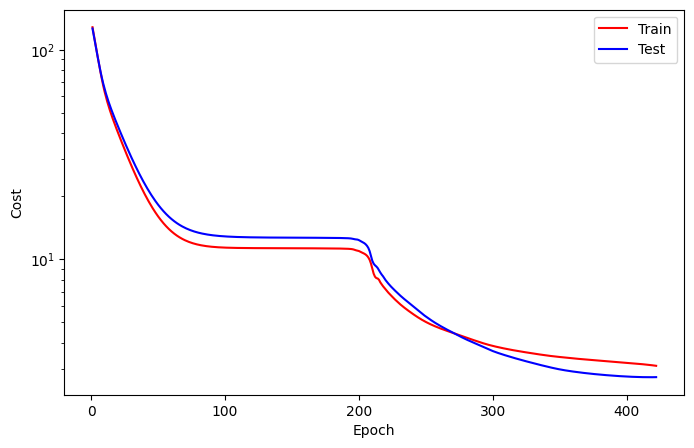

In [27]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)

    # logging
    callback.log(train_cost, test_cost)

    # checkpoint
    callback.save_checkpoint()

    # runtime plotting
    callback.cost_runtime_plotting()

    # early stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

<h2> Forecast

In [17]:
def data4pred(model, dataset, dataloader, device):
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)

            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()

def pred4pred(model, dataset, dataloader, device, n_prior=75, n_forecast=30):
    preds, targets = [], []
    hidden = None
    end = n_prior + n_forecast
    with torch.no_grad():
        model.eval()
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]

            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)

            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1) # forecasting jadi per 1 data, input 1 pred 1
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (417, 1, 1)
Note: last 0 data excluded

(N, S, F): (104, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

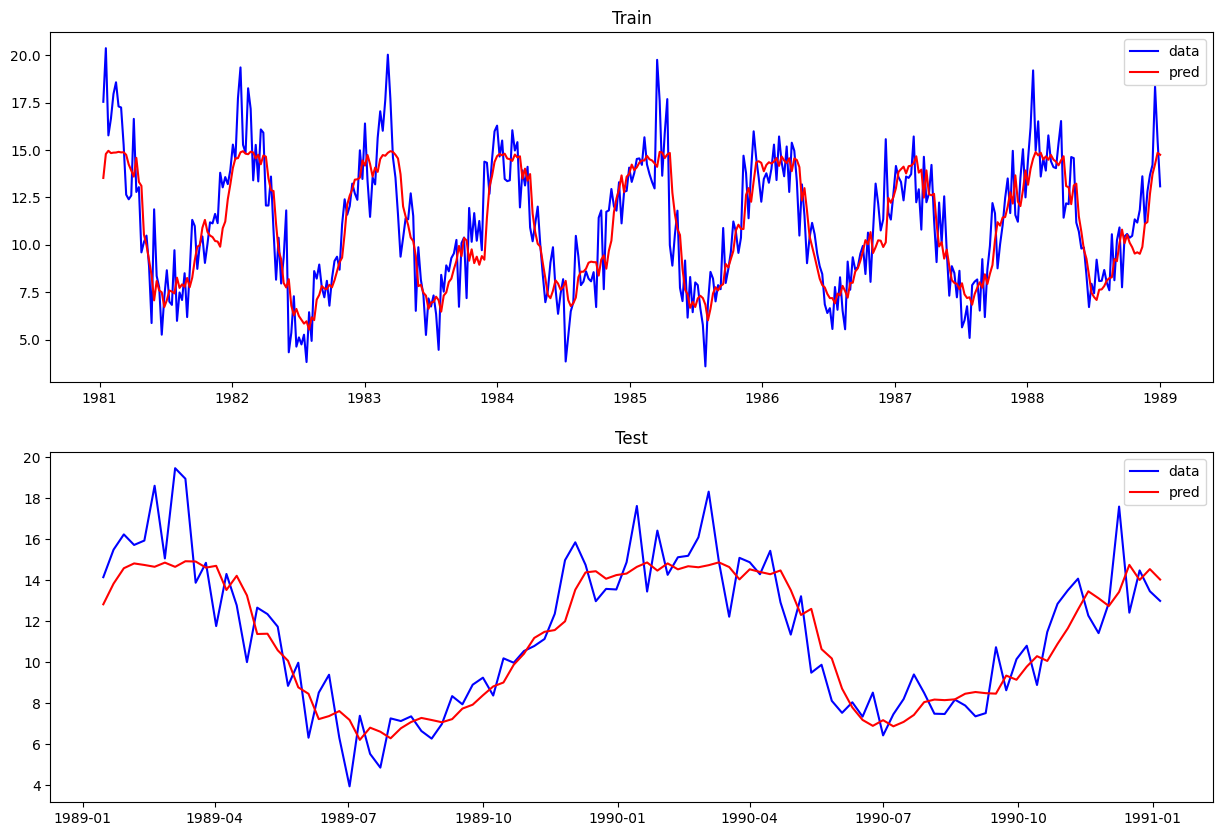

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'Test')

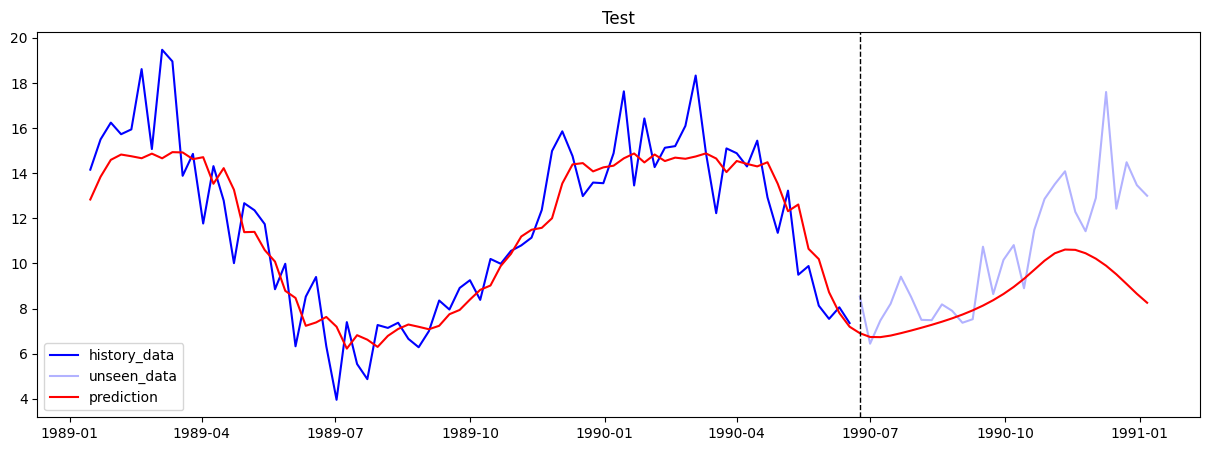

In [29]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")